# Avaliação da empresa "Banco do Brasil S.A" (BBAS3)

---



Um modelo de avaliação de ações, conhecido como "valuation", é uma ferramenta que transforma um conjunto de previsões ou observações sobre variáveis da empresa e fatores econômicos em uma estimativa do valor de mercado de uma ação.

As entradas para esse tipo de modelo incluem variáveis econômicas, como lucros futuros, dividendos e flutuações nos lucros, entre outras.

O objetivo é estimar o valor de mercado esperado ou o retorno esperado de manter uma ação, ou fornecer uma recomendação de compra, venda ou manutenção.

Existem diversos métodos de avaliação, cada um usado de maneiras distintas pelas empresas para validar suas premissas. Aqui, vamos utilizar um modelo básico de determinação do preço teórico de uma ação, que considera poucos insumos. Essa abordagem, embora simplificada, é útil para entender o processo de valuation.

Modelo de Fluxo de Caixa Descontado
Os modelos de fluxo de caixa descontado (DCF) baseiam-se na premissa de que o valor de uma ação corresponde ao valor presente dos fluxos de caixa futuros que o acionista espera receber.

Variáveis de Entrada:
SG: Calculada a partir do ROE e Payout obtidos no Yahoo Finance.
CAPM: Com a taxa de referência de swaps DI pré-360 dias como taxa livre de risco, retorno de mercado de 15% ao ano, e beta da ação.
Dividendo Esperado: Média dos dividendos anuais históricos da BBAS3.
Com essas variáveis, podemos implementar o modelo de crescimento constante no Python para calcular o preço teórico da ação.

In [1]:
! pip install ipeadatapy

In [2]:
import pandas as pd
import numpy as np
import yfinance as yf
import ipeadatapy as ip
from plotnine import *

# Taxa de Crescimento (g):

In [3]:
ticker = "BBAS3.SA"
price = yf.download(ticker, period = '1d')['Adj Close']
price.head()

[*********************100%***********************]  1 of 1 completed


,Adj Close
Date,
2024-09-05,28.950001


In [4]:
data = yf.Ticker(ticker)
dividends = data.dividends
dividends.head()

,Dividends
Date,
2009-06-23 00:00:00-03:00,0.090111
2009-08-14 00:00:00-03:00,0.095437
2009-09-22 00:00:00-03:00,0.092699
2009-11-13 00:00:00-02:00,0.061449
2009-12-22 00:00:00-02:00,0.094522


In [5]:
# Calculo do g:

g = data.info['returnOnEquity']*(1-data.get_info()['payoutRatio'])
g

0.1483500075

Taxa exigida pelos investidores:

In [8]:
# beta fornecido pelo Yahoo

beta = data.info['beta']

juros_livre = (
    ip.timeseries('BMF12_SWAPDI36012')
    .rename(columns = {'VALUE ((% a.a.))' : 'swaps'})[['swaps']]
    .div(100)
    .iloc[-1]
    .swaps
  )

juros_livre

retorno = 0.125


# Cálculo do r:
---

In [9]:
# calcula o custo do capital
r = juros_livre + beta * (retorno - juros_livre)
r

0.12289279090909087

In [10]:
anual_dividendos = (
    pd.DataFrame(dividends)
    .tz_localize(None)
    .assign(Year = lambda x: x.index.year)
    .groupby(['Year']) # agrupa por ano
    .agg({'Dividends' : 'sum'}) # soma os dividendos do ano
    .iloc[:-1]
)

anual_dividendos

,Dividends
Year,
2009,0.434218
2010,0.893389
2011,0.928628
2012,0.812912
2013,1.188493
2014,0.830012
2015,1.030820
2016,0.456858
2017,0.472985


# Gerando o gráfico de dividendos:
---

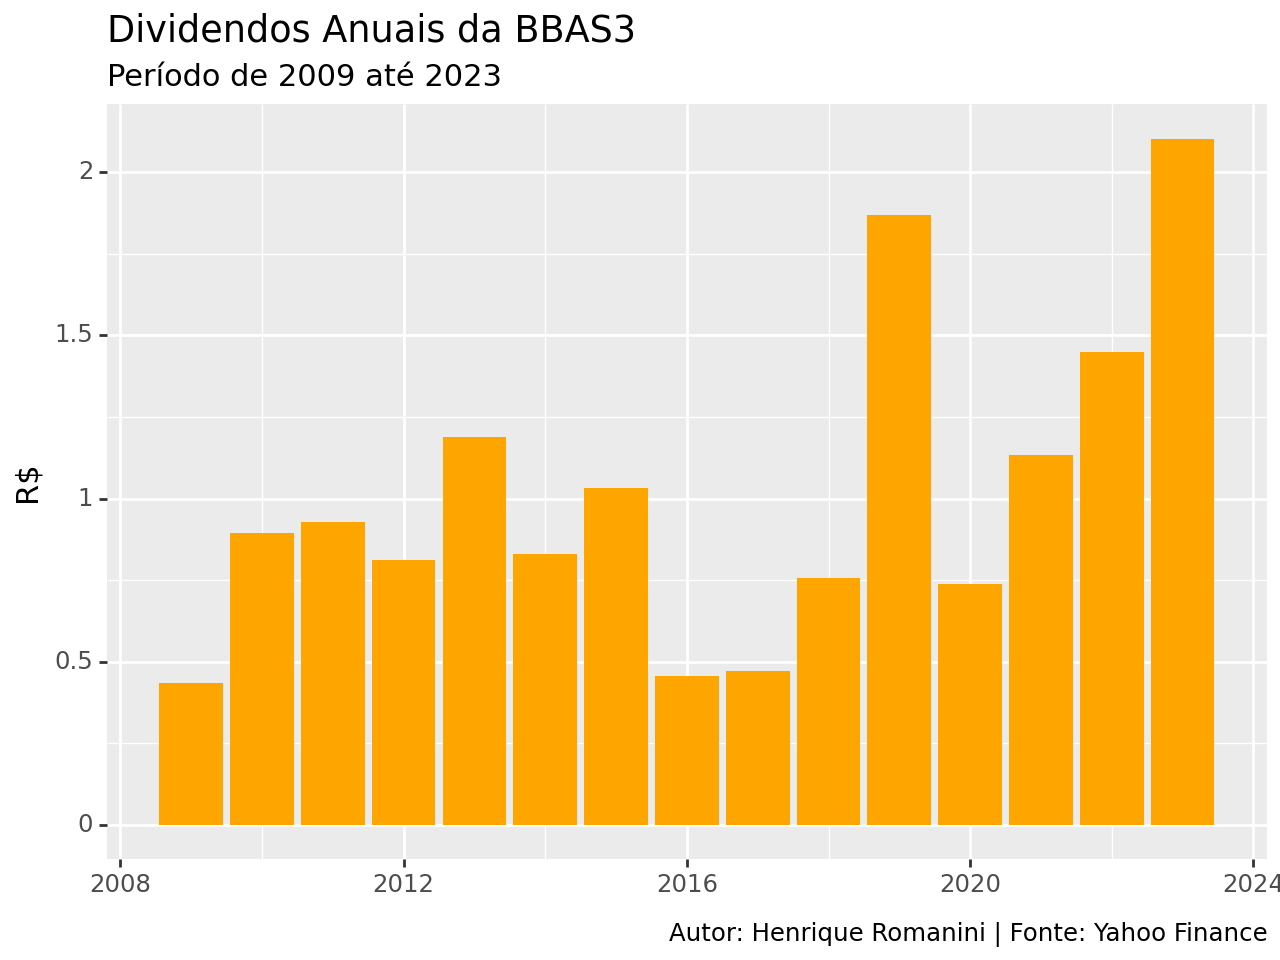

<Figure Size: (640 x 480)>

In [11]:
anual_dividendos_reindex = anual_dividendos.reset_index()

(ggplot(anual_dividendos_reindex, aes(x = 'Year', y = "Dividends"))
  + geom_col(fill = 'orange')
  + labs(title = 'Dividendos Anuais da BBAS3', subtitle = "Período de 2009 até 2023",
         caption = "Autor: Henrique Romanini | Fonte: Yahoo Finance",
         x = "",
         y = "R$"))

# Comparando o preço teórico com o valor atual:

In [12]:
D_esperado = anual_dividendos.mean().Dividends

# Calculando o valor presente líquido da ação (PV)
PV = D_esperado / (g - r)

print(f"Valor presente da ação {ticker}: R$ {PV:.2f}")
print(f"Valor da ação {ticker}: R$ {price.values[0]:.2f}")

Valor presente da ação BBAS3.SA: R$ 39.53
Valor da ação BBAS3.SA: R$ 28.95


Considerando o resultado final, concluimos que as ações do Banco do Brasil S.A estão abaixo do valor de mercado de acordo o método utilizado

Agora faremos uma análise para avaliar o futuro dessa ação baseada na análise de séries temporais:

# Série temporal
---


In [13]:
! pip install Prophet

In [31]:
from prophet import Prophet
import seaborn as sns
import matplotlib.pyplot as plt

Agora importaremos o valor da BBAS3 nos ultimos 24 meses

In [15]:
prices = yf.download(ticker, period = '2y')["Adj Close"].reset_index()
prices.columns = ["ds", "y"]
prices.head()

[*********************100%***********************]  1 of 1 completed


,ds,y
0,2022-09-05,17.409435
1,2022-09-06,16.573044
2,2022-09-08,16.501947
3,2022-09-09,16.957783
4,2022-09-12,17.221249


Usando a biblioteca Phophet avaliaremos o comportamento futuro por meio das séries temporais. Treinaremos o modelo e verificaremos as probabilidades de retorno a longo prazo.

In [50]:
model = Prophet(interval_width=0.95)
model.fit(prices)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmper56l_rd/y8fen32k.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmper56l_rd/omhsb0za.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12740', 'data', 'file=/tmp/tmper56l_rd/y8fen32k.json', 'init=/tmp/tmper56l_rd/omhsb0za.json', 'output', 'file=/tmp/tmper56l_rd/prophet_model9f4enayz/prophet_model-20240905150833.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:08:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:08:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [51]:
previsoes = model.make_future_dataframe(periods = 365)
previsoes.tail()

,ds
860,2025-09-01
861,2025-09-02
862,2025-09-03
863,2025-09-04
864,2025-09-05


In [59]:
from prophet.plot import plot_plotly

st = model.predict(previsoes)

fig = plot_plotly(model, st)

/usr/local/lib/python3.10/dist-packages/_plotly_utils/basevalidators.py:105: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



A seguir o gráfico com as previsões:

In [61]:
import plotly.io as pio

# Gerando a figura com plot_plotly
fig = plot_plotly(model, st)

# Personalizando o título e layout
fig.update_layout(
    title="Previsão do Preço das Ações BBAS3",
    xaxis_title="Data",
    yaxis_title="Preço (R$)",
    legend_title="Legenda",

    font=dict(
        family="Arial, monospace",
        size=18,
        color="RebeccaPurple"
    ),
    title_font=dict(size=24),
    plot_bgcolor="rgba(240, 240, 240, 0.95)"  # Cor de fundo
)

fig.add_annotation(
    text="Autor: Henrique Romanini | Fonte: Yahoo Finance",
    xref="paper", yref="paper",
    x=0.5, y=-0.2,  # Posição do caption (centralizado abaixo do gráfico)
    showarrow=False,
    font=dict(size=12),
    align="center"
)

# Mostrando o gráfico
fig.show()


/usr/local/lib/python3.10/dist-packages/prophet/plot.py:228: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

/usr/local/lib/python3.10/dist-packages/prophet/plot.py:351: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

/usr/local/lib/python3.10/dist-packages/prophet/plot.py:354: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



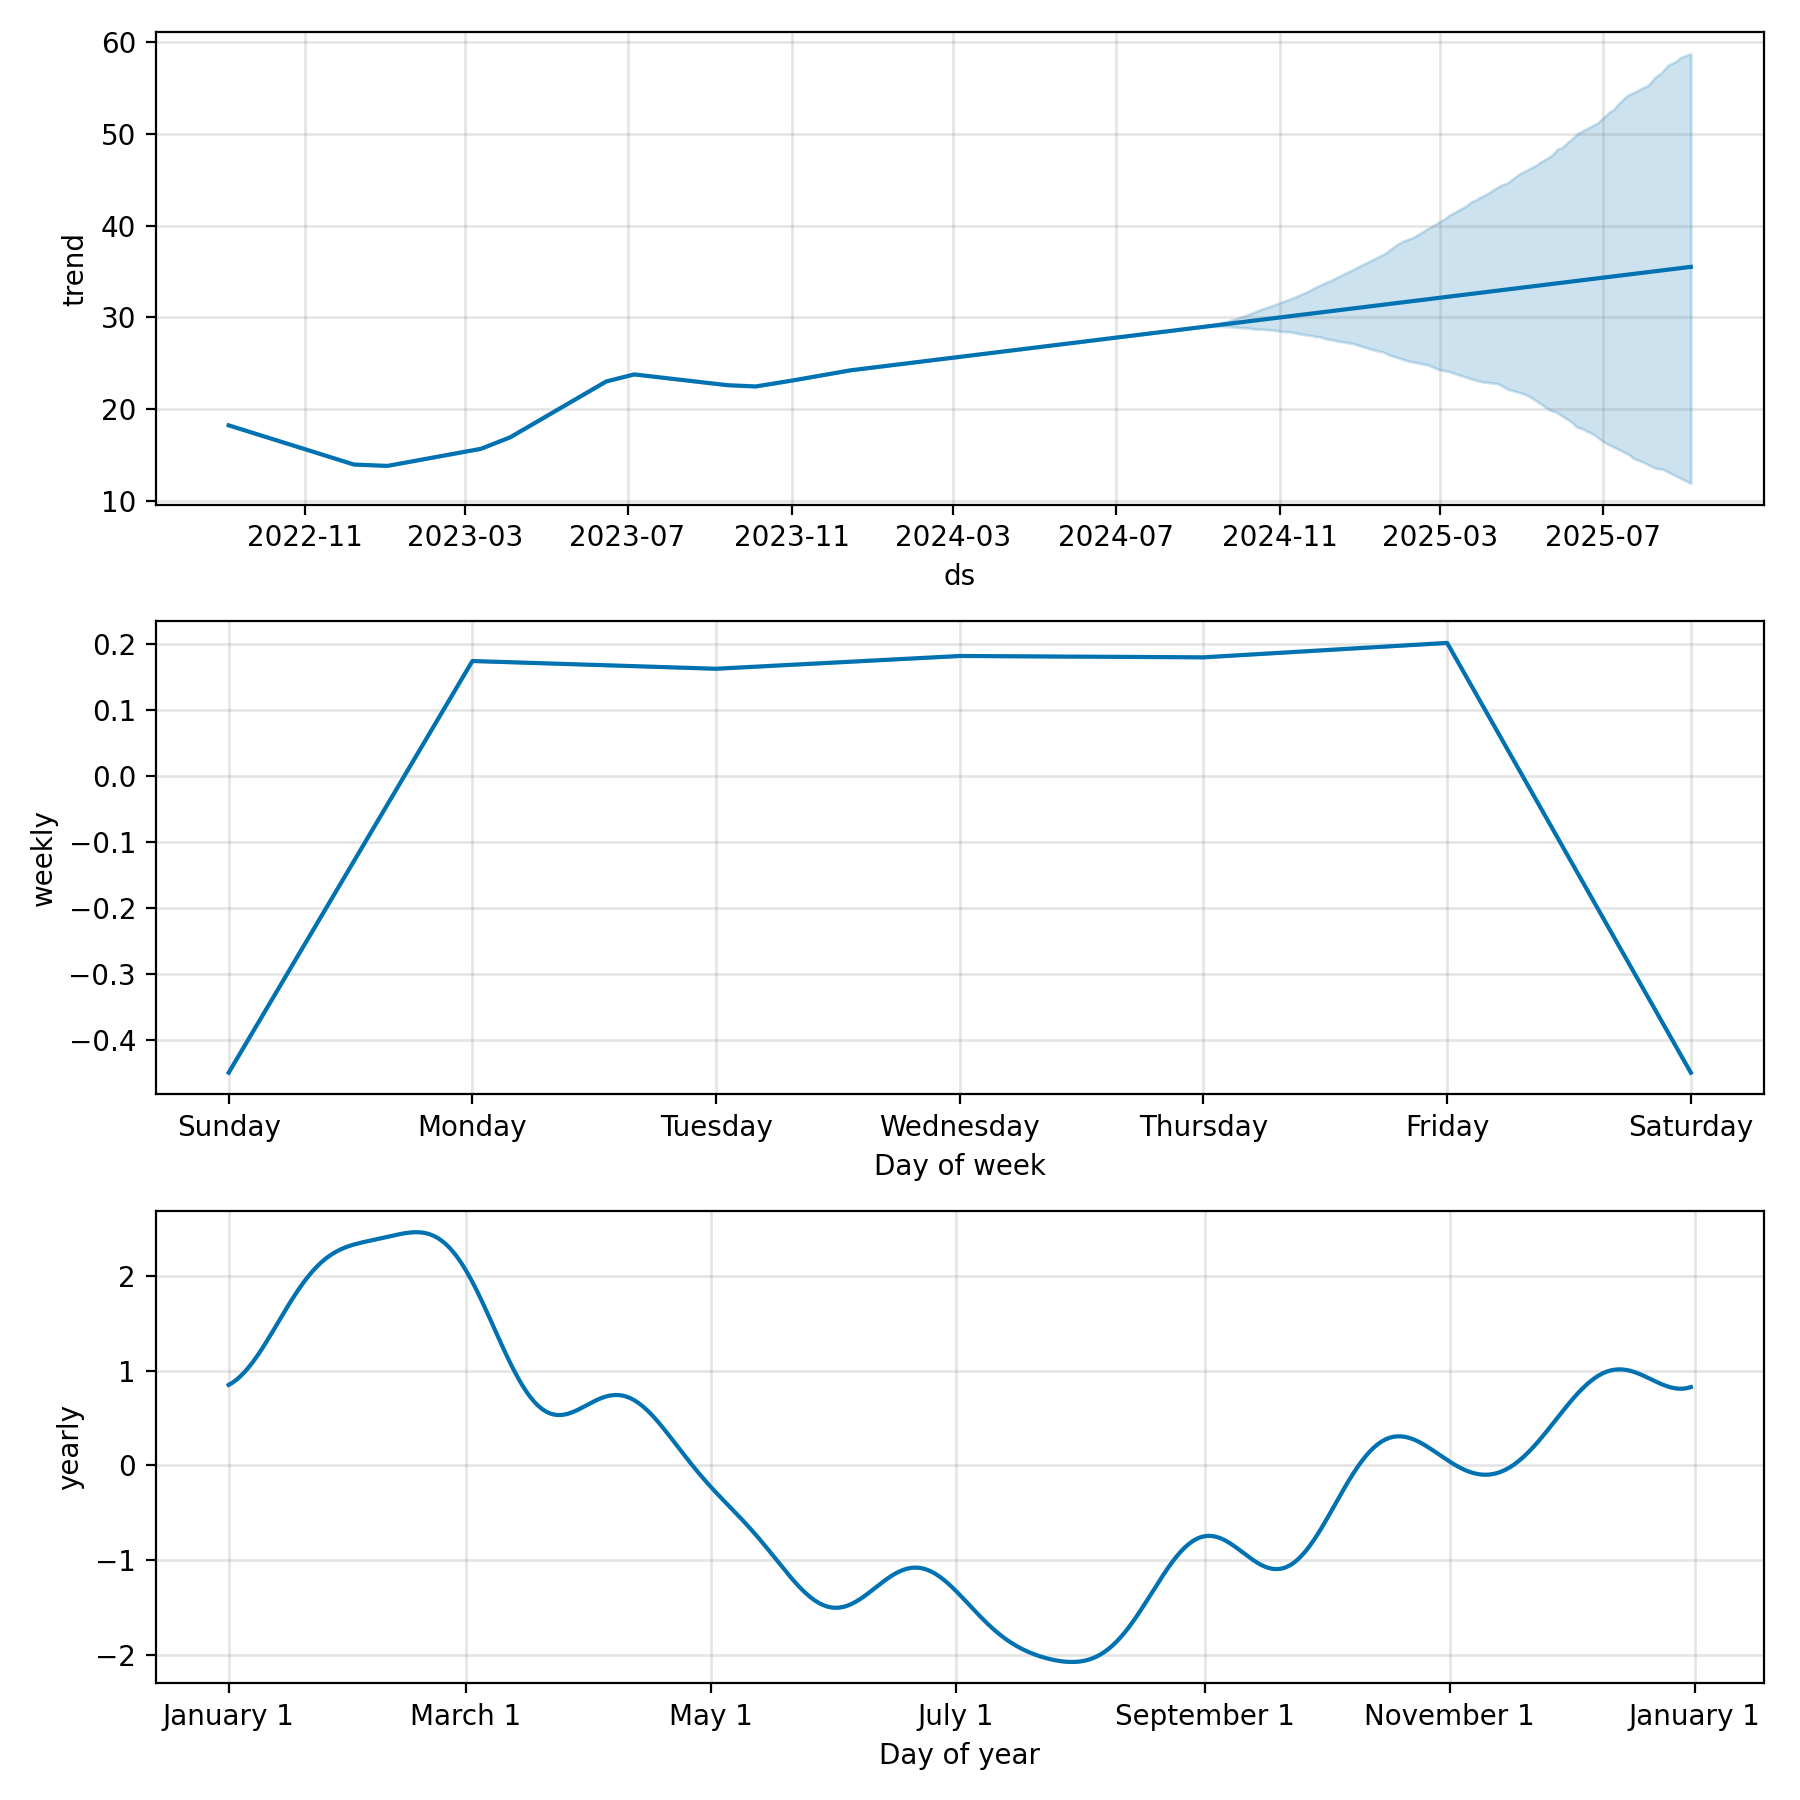

In [65]:
from prophet.plot import plot_components

fig2 = plot_components(model, st)

fig2.show()

# Conclusão e Recomendação de Compra
---

Neste relatório, realizamos uma análise detalhada utilizando o modelo Prophet para prever o comportamento futuro da ação analisada. Com base nas nossas avaliações e no valuation realizado, concluímos que o valor intrínseco da ação é superior à sua cotação atual. Além disso, as previsões geradas pelo modelo Prophet indicam uma tendência de alta para a ação, corroborando a análise inicial.

Resumo das Análises:

Valuation da Ação: O valuation demonstrou que o valor real da ação é maior que o preço de mercado atual. Este resultado sugere que a ação está subvalorizada e pode representar uma oportunidade de compra atraente.

Previsão do Modelo Prophet: A análise do modelo Prophet, com um intervalo de confiança ajustado para 95%, prevê uma tendência de alta para a ação. Esta previsão está alinhada com a avaliação, reforçando a expectativa de valorização futura.

Sazonalidade: A sazonalidade indica que esse periodo é o de maior baixa e portanto reforça a oportunidade de compra.

Recomendação:

Com base nas análises realizadas, recomendamos a compra da ação analisada. A combinação de um valuation que aponta para uma ação subvalorizada e um modelo de previsão que sugere uma tendência de alta oferece uma oportunidade potencialmente vantajosa para investidores.

Considerações Importantes:

É fundamental ressaltar que o modelo Prophet, apesar de fornecer uma visão valiosa sobre a tendência futura da ação, não leva em consideração eventos extraordinários ou crises econômicas. O modelo é baseado em dados históricos e pode não prever mudanças abruptas ou imprevistas no mercado que possam impactar significativamente o desempenho da ação.

Portanto, recomendamos que, além de considerar nossas análises, os investidores monitorem continuamente o mercado e estejam preparados para ajustar suas estratégias conforme novas informações se tornem disponíveis. A diversificação e a avaliação constante dos riscos são práticas recomendadas para mitigar possíveis impactos negativos.